# Big Shadow State Tomography

Quantum computers can solve some problems exponentially faster than classical ones, but their possibilities are still limited by high levels of noise, so quantum advantage has not been reached yet. To compensate for the noise, quantum error correction techniques can be applied by encoding one logical qubit into many physical qubits. This, in turn, requires the availability of a large number of physical qubits. 
The quantum software and hardware are evolving at a surprising speed: IBM Quantum surpassed the 100-qubit processor milestone in 2021 and has ambitious plans through 2023 [1]. 


![image.png](Fig1_IBMdevolopment_roadmap.png) 

*Fig.1. IBM Development Roadmap. Image source [1].*

In addition to advancements in software, significant improvements can also be made in quantum algorithms and processes, such as compilation. These enhancements are crucial for optimizing performance and making quantum computing more practical and efficient.

Here, we compare the speed of standard Qiskit compilation with the compilation using the Rivet transpiler. As benchmark circuits, we selected the case of shadow state tomography (for more details, please check the notebook [Shadow State Tomography](../shadows/shadow_state_tomography.ipynb)). Except for error correction, estimating compilation for a large number of qubits has multiple purposes, such as scalability, effective resource management, and performance prediction.

## 1. Installation and Imports
To run the code below make sure you have followed and installed Rivet transpiler. Check the installation steps from   **Readme.md**.

#### 1.1. Import Qiskit and Rivet Transpiler Functions Required to Run the Examples Below

In [1]:
import numpy as np

from time import time
from tqdm import tqdm

import qiskit

from qiskit_aer import AerSimulator
from qiskit.visualization import plot_gate_map 
 
from qiskit_ibm_runtime.fake_provider import FakeKyiv

from qiskit.circuit.random import random_circuit

import matplotlib.pyplot as plt

# plt.style.use("dark_background")

%cd -q ../..

from rivet_transpiler import transpile_right

In [2]:
def build_bases_rotation_circuit(bases):

    qubits_count = len(bases)

    circuit = qiskit.QuantumCircuit(qubits_count)

    for qubit, basis in enumerate(bases):

        if basis == "X":
            circuit.h(qubit)

        elif basis == "Y":
            circuit.sdg(qubit)
            circuit.h(qubit)

        elif basis == "Z":
            pass

    return circuit

#### 1.2. Import Backend

Available backends from IBM Qiskit are listed at [2].  To run this example we select the backend with 127 qubits:

In [3]:
FAKE_BACKEND = FakeKyiv()

backend = AerSimulator.from_backend(FAKE_BACKEND)

# backend.options.noise_model = None

# qiskit.visualization.plot_gate_map(FAKE_BACKEND)

![image.png](Fig2_127qubit_IBMbackend_topology.png) 

*Fig.2. Schematic representation of FakeKyiv backend (127 qubits).*

### Circuit

In [24]:
# Parameters

QUBITS_COUNT = 127
CIRCUIT_DEPTH = 1
MAX_GATE_SIZE = 4

BASES_COUNT = 1

OPTIMIZATION_LEVEL = 3

SEED = 1234

rng = np.random.default_rng(SEED) 

qubits = list(range(QUBITS_COUNT))

## Random Circuit

circuit = random_circuit(
    num_qubits=QUBITS_COUNT, 
    depth=CIRCUIT_DEPTH,
    max_operands=MAX_GATE_SIZE, 
    seed=SEED,
    measure=False)

# circuit.draw(fold=-1)
# circuit.draw(fold=-1, output="mpl")

### Measurement Bases

In [5]:
random_bases = rng.choice(['X','Y','Z'], size=(BASES_COUNT, QUBITS_COUNT))

bases_list, shots_counts = np.unique(random_bases, axis=0, return_counts=True)

bases_list.shape

(1, 127)

In [6]:
rotation_circuits = []

for bases in bases_list:

    rotation_circuit = build_bases_rotation_circuit(bases)

    rotation_circuits.append(rotation_circuit)

len(rotation_circuits)

1

### Basic Transpilation - Slower Version!


In [7]:
start_time = time()

# Compose and Transpile all Rotation Circuits

shadow_circuits = []

rotation_tracker = tqdm(rotation_circuits, unit=' basis', ncols=110)

for rotation_circuit in rotation_tracker:

    measurement_circuit = rotation_circuit.measure_all(inplace=False)

    measured_circuit = circuit.compose(measurement_circuit)

    # display(measured_circuit.draw(fold=-1))

    shadow_circuit = qiskit.transpile(
        measured_circuit,
        backend,
        seed_transpiler=SEED,
        optimization_level=OPTIMIZATION_LEVEL)

    shadow_circuits.append(shadow_circuit)

estimated_time = time() - start_time

print(f"estimated_time: {estimated_time:.02f}")

100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.49s/ basis]

estimated_time: 12.49


### Transpile Right - Much Faster!

In [8]:
start_time = time()

# Transpile Central Part

transpiled_central_circuit = qiskit.transpile(
    circuit,
    backend,
    seed_transpiler=SEED,
    optimization_level=OPTIMIZATION_LEVEL)


# Transpile Right all Rotation Circuits

shadow_circuits = []

rotation_tracker = tqdm(rotation_circuits, unit=' basis', ncols=110)

for rotation_circuit in rotation_tracker:

    measurement_circuit = rotation_circuit.measure_all(inplace=False)

    shadow_circuit = transpile_right(
        transpiled_central_circuit,
        measurement_circuit,
        backend=backend,
        seed_transpiler=SEED,
        optimization_level=OPTIMIZATION_LEVEL)

    shadow_circuits.append(shadow_circuit)


estimated_time = time() - start_time

print(f"estimated_time: {estimated_time:.02f}")

100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.94 basis/s]

estimated_time: 11.64


### Compare Transpilation Times

In [9]:
bases_counts = list(range(1, 1000))

basic_transpile_time = 20
transpile_central_time = 18
transpile_right_time = 0.2

In [10]:
basic_transpile_totals = []
transpile_right_totals = []

for bases_count in bases_counts:

    basic_transpile_total = bases_count * basic_transpile_time

    transpile_right_total = transpile_central_time + bases_count * transpile_right_time
    
    basic_transpile_totals.append(basic_transpile_total)
    transpile_right_totals.append(transpile_right_total)

### Plots

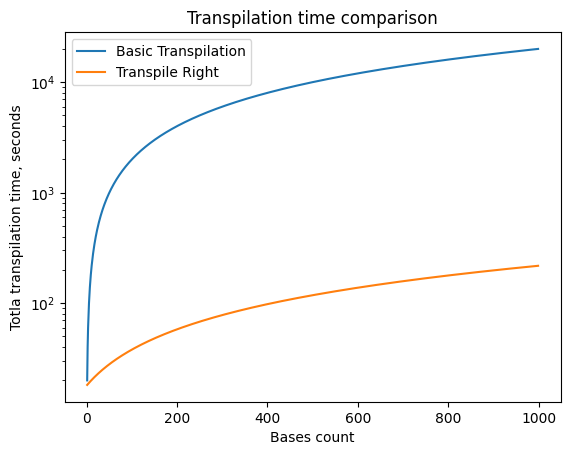

In [23]:
# Plot Transpilation times

plt.title("Transpilation time comparison")
plt.xlabel("Bases count")
plt.ylabel("Total transpilation time, seconds")

plt.plot(bases_counts, basic_transpile_totals, label="Basic Transpilation")
plt.plot(bases_counts, transpile_right_totals, label="Transpile Right")

plt.gca().set_yscale('log')

plt.legend()
plt.show()